## About the Problem
Lung segmentation from chest X-ray or CT images is essential in medical imaging to analyze lung abnormalities such as infections, tumors, or lung diseases. The goal is to segment the lung regions from grayscale medical images.


## About the Dataset
The dataset used is the 'Lung Image Segmentation Dataset' dataset from Kaggle.This dataset contains over 500 x-ray scans with clinical labels collected by radiologists.

Acknowledgements:

The two datasets were published together in an analysis here: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4256233/.
The datasets come from Shenzhen and Montgomery, respectively.

1. **Shenzhen Set (China)**:
   - Created by the National Library of Medicine in collaboration with Shenzhen No. 3 People’s Hospital.
   - Captured using Philips DR Digital Diagnose systems.
   - Includes 336 tuberculosis cases and 326 normal cases.
   
2. **Montgomery County X-ray Set (USA)**:
   - Collected from the tuberculosis control program of Montgomery County, Maryland, USA.
   - Contains 138 posterior-anterior X-ray scans.
   - Includes 80 normal cases and 58 tuberculosis cases.


## Step 1: Import Libraries

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Concatenate, Input
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

## Step 2: Load and Explore Dataset

In [2]:
# Set dataset paths
image_dir = "/kaggle/input/lung-segment/images"
mask_dir = "/kaggle/input/lung-segment/masks"

def load_dataset(image_dir, mask_dir, img_size=(256, 256)):
    images, masks = [], []

    # Extract available mask filenames without "-mask"
    mask_files = {filename.split('-mask')[0]: filename for filename in os.listdir(mask_dir)}

    matched_count = 0
    for filename in os.listdir(image_dir):
        base_name = filename.split('.')[0]  # Extract base name
        
        if base_name in mask_files:  # Only keep images that have masks
            img_path = os.path.join(image_dir, filename)
            mask_path = os.path.join(mask_dir, mask_files[base_name])

            img = load_img(img_path, target_size=img_size, color_mode='grayscale')
            mask = load_img(mask_path, target_size=img_size, color_mode='grayscale')

            images.append(img_to_array(img) / 255.0)
            masks.append(img_to_array(mask) / 255.0)
            matched_count += 1
        else:
            print(f"Skipping {filename}: No corresponding mask found.")

    print(f"Total images with masks loaded: {matched_count}")
    return np.array(images).reshape(-1, 256, 256, 1), np.array(masks).reshape(-1, 256, 256, 1)
 
# Load images and masks
X, Y = load_dataset(image_dir, mask_dir)

Skipping 94.png: No corresponding mask found.
Skipping 771.png: No corresponding mask found.
Skipping 761.png: No corresponding mask found.
Skipping 403.png: No corresponding mask found.
Skipping 35.png: No corresponding mask found.
Skipping 628.png: No corresponding mask found.
Skipping 441.png: No corresponding mask found.
Skipping 296.png: No corresponding mask found.
Skipping 538.png: No corresponding mask found.
Skipping 89.png: No corresponding mask found.
Skipping 411.png: No corresponding mask found.
Skipping 281.png: No corresponding mask found.
Skipping 362.png: No corresponding mask found.
Skipping 660.png: No corresponding mask found.
Skipping 256.png: No corresponding mask found.
Skipping 4.png: No corresponding mask found.
Skipping 588.png: No corresponding mask found.
Skipping 229.png: No corresponding mask found.
Skipping 331.png: No corresponding mask found.
Skipping 575.png: No corresponding mask found.
Skipping 673.png: No corresponding mask found.
Skipping 658.png: 

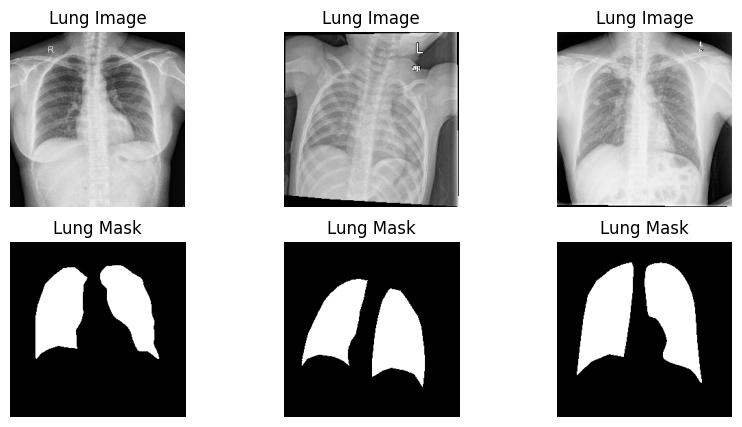

In [17]:
# Display sample images
plt.figure(figsize=(10,5))
for i in range(3):
    plt.subplot(2,3,i+1)
    plt.imshow(X[i].squeeze(), cmap='gray')
    plt.title("Lung Image")
    plt.axis('off')
    
    plt.subplot(2,3,i+4)
    plt.imshow(Y[i].squeeze(), cmap='gray')
    plt.title("Lung Mask")
    plt.axis('off')
plt.show()



## Step 3: Preprocess Data

In [4]:
# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

## Step 4: Define U-Net Model

In [5]:
def unet_model(input_size=(256, 256, 1)):
    inputs = Input(input_size)
    
    # Encoder
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
    
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
    
    # Bottleneck
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    
    # Decoder
    u1 = UpSampling2D((2, 2))(c4)
    u1 = Concatenate()([u1, c3])
    c5 = Conv2D(256, (3, 3), activation='relu', padding='same')(u1)
    c5 = Conv2D(256, (3, 3), activation='relu', padding='same')(c5)
    
    u2 = UpSampling2D((2, 2))(c5)
    u2 = Concatenate()([u2, c2])
    c6 = Conv2D(128, (3, 3), activation='relu', padding='same')(u2)
    c6 = Conv2D(128, (3, 3), activation='relu', padding='same')(c6)
    
    u3 = UpSampling2D((2, 2))(c6)
    u3 = Concatenate()([u3, c1])
    c7 = Conv2D(64, (3, 3), activation='relu', padding='same')(u3)
    c7 = Conv2D(64, (3, 3), activation='relu', padding='same')(c7)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c7)
    
    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

## Step 5: Train Model

In [6]:
# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

In [7]:
model = unet_model()
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=8, callbacks=[early_stopping, reduce_lr])

Epoch 1/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 127s 1s/step - accuracy: 0.7160 - loss: 0.6104 - val_accuracy: 0.7469 - val_loss: 0.4035 - learning_rate: 0.0010
Epoch 2/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 29s 405ms/step - accuracy: 0.7960 - loss: 0.3713 - val_accuracy: 0.7472 - val_loss: 0.3782 - learning_rate: 0.0010
Epoch 3/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 29s 405ms/step - accuracy: 0.7816 - loss: 0.3541 - val_accuracy: 0.8794 - val_loss: 0.2712 - learning_rate: 0.0010
Epoch 4/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 29s 405ms/step - accuracy: 0.9279 - loss: 0.1882 - val_accuracy: 0.9496 - val_loss: 0.1331 - learning_rate: 0.0010
Epoch 5/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 29s 403ms/step - accuracy: 0.9524 - loss: 0.1304 - val_accuracy: 0.9656 - val_loss: 0.0941 - learning_rate: 0.0010
Epoch 6/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 28s 401ms/step - accuracy: 0.9685 - loss: 0.0868 - val_accuracy: 0.9647 - val_loss: 0.0960 - learning_rate: 0.0010
Epoch 7/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 29s 403ms/step - accuracy: 0.9719 - loss: 0.07

## Step 6: Evaluate Model

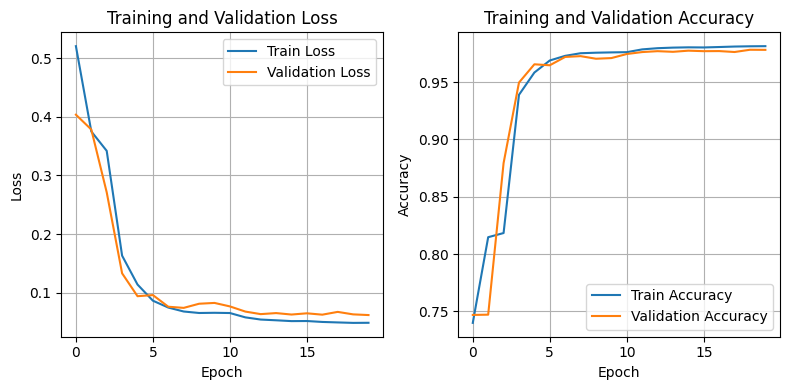

In [8]:
# Plotting training and validation loss
plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)


# Plotting training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Showing X-ray, original mask, and predicted mask:


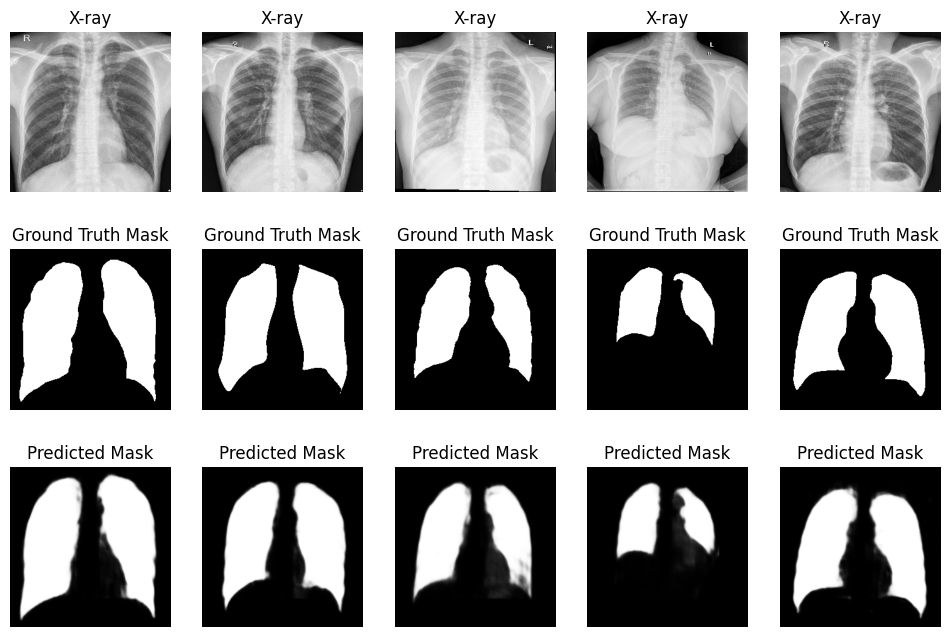

In [29]:
# Display predictions
pred = model.predict(X_test[:5])

print("Showing X-ray, original mask, and predicted mask:")
plt.figure(figsize=(12,8))
for i in range(5):
    plt.subplot(3,5,i+1)
    plt.imshow(X_test[i].squeeze(), cmap='gray')
    plt.title("X-ray")
    plt.axis('off')

    plt.subplot(3,5,i+6)
    plt.imshow(y_test[i].squeeze(), cmap='gray')
    plt.title("Ground Truth Mask")
    plt.axis('off')

    plt.subplot(3,5,i+11)
    plt.imshow(pred[i].squeeze(), cmap='gray')
    plt.title("Predicted Mask")
    plt.axis('off')

plt.show()

## Step7: Calculate Dice score

In [12]:
import numpy as np

def dice_score(y_true, y_pred, threshold=0.5):
 
    # Convert predictions to binary (0 or 1)
    y_pred_bin = (y_pred > threshold).astype(np.uint8)
    
    # Flatten the arrays
    y_true_flat = y_true.flatten()
    y_pred_flat = y_pred_bin.flatten()
    
    # Compute intersection and union
    intersection = np.sum(y_true_flat * y_pred_flat)
    union = np.sum(y_true_flat) + np.sum(y_pred_flat)
    
    # Compute Dice Score
    dice = (2. * intersection) / (union + 1e-7)  # Add small value to avoid division by zero
    return dice

In [24]:
# Generate predictions
y_pred = model.predict(X_test)


# Compute Dice Score
score = dice_score(y_test, y_pred)
print(f"Dice Score: {score:.4f}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 340ms/step
Dice Score: 0.9563
